# Fast qfunc
The aim of this notebook is to speed up the computation of the Husimi Q function.

This is done by computing a large matrix in advance, and 

In [1]:
import line_profiler
%load_ext line_profiler

import matplotlib.pyplot as plt

In [2]:
import numpy as np
from scipy import (zeros, array, arange, exp, real, conj, pi,
                   copy, sqrt, meshgrid, size, polyval, fliplr, conjugate,
                   cos, sin)
import scipy.sparse as sp
import scipy.fftpack as ft
import scipy.linalg as la
from scipy.special import genlaguerre
from scipy.special import binom
from scipy.special import sph_harm

from qutip.qobj import Qobj, isket, isoper
from qutip.states import ket2dm
from qutip.parallel import parfor
from qutip.utilities import clebsch
from scipy.special import factorial
from qutip.cy.sparse_utils import _csr_get_diag

import scipy.linalg as la
from qutip.qobj import Qobj, isket, isoper
from qutip import (tensor, qeye, coherent, expect)

In [3]:
def qfunc(state, xvec, yvec, g=sqrt(2), amat_pwr=None):
    """Q-function of a given state vector or density matrix
    at points `xvec + i * yvec`.

    Parameters
    ----------
    state : qobj
        A state vector or density matrix.

    xvec : array_like
        x-coordinates at which to calculate the Wigner function.

    yvec : array_like
        y-coordinates at which to calculate the Wigner function.

    g : float
        Scaling factor for `a = 0.5 * g * (x + iy)`, default `g = sqrt(2)`.

    amat_pwr : array
        The matrix provided by qfunc_amat(xvec, yvec, n, g), where xvec, yvec and g
        need to be the same as for qfunc, and n = np.prod(state.shape) is the dim
        of a pure state in the chosen system.
        If provided, the pure qfunc is computed with _qfunc_pure_fast, which has
        significant speedup over _qfunc_pure. Useful if Q is computed for density
        matrices or many times.

    Returns
    --------
    Q : array
        Values representing the Q-function calculated over the specified range
        [xvec,yvec].

    """
    X, Y = meshgrid(xvec, yvec)
    amat = 0.5 * g * (X + Y * 1j)

    if not (isoper(state) or isket(state)):
        raise TypeError('Invalid state operand to qfunc.')

    qmat = zeros(size(amat))

    if isket(state):
        qmat = _qfunc_pure(state, amat, amat_pwr)
    elif isoper(state):
        d, v = la.eig(state.full())
        # d[i]   = eigenvalue i
        # v[:,i] = eigenvector i

        qmat = zeros(np.shape(amat))
        for k in arange(0, len(d)):
            qmat1 = _qfunc_pure(v[:, k], amat, amat_pwr)
            qmat += real(d[k] * qmat1)

    qmat = 0.25 * qmat * g ** 2
    return qmat

In [4]:
def _qfunc_pure(psi, alpha_mat, amat_pwr=None):
    """
    Calculate the Q-function for a pure state.

    If provided, amat_pwr needs to be computed with qfunc_amat(xvec, yvec, n, g), where xvec, yvec and g
    need to be the same as for qfunc, and n = np.prod(state.shape) is the dim
    of a pure state in the chosen system. This gives 3-10x speedup for each call
    """
    n = np.prod(psi.shape)
    if isinstance(psi, Qobj):
        psi = psi.full().flatten()
    else:
        psi = psi.T

    if amat_pwr is None:
        qmat = polyval(fliplr([psi / sqrt(factorial(arange(n)))])[0],
                           conjugate(alpha_mat))
    else:
        qmat = np.dot(amat_pwr, psi)
    # faster than np.abs()**2 if len(xvec) >~ 10
    qmat = qmat.real**2 + qmat.imag**2
    if amat_pwr is None:
        qmat *= exp(-abs(alpha_mat) ** 2)
    return qmat / pi

In [5]:
def qfunc_amat(xvec, yvec, n, g=sqrt(2)):
    """Helper matrix for fast Q-function at points `xvec + i * yvec`.

    Warning: The returned array has size len(xvec) * len(yvec) * n, can be large

    Parameters
    ----------
    xvec : array_like
        x-coordinates at which to calculate the Wigner function.

    yvec : array_like
        y-coordinates at which to calculate the Wigner function.

    g : float
        Scaling factor for `a = 0.5 * g * (x + iy)`, default `g = sqrt(2)`.

    Returns
    --------
    amat_pwr : array
        Precomputed array that contains everything in _qfunc_pure that is not dependent on
        the state.

    """
    X, Y = meshgrid(xvec, yvec)
    amat = 0.5 * g * (X - Y * 1j)

    powers = np.arange(n)
    amat_pwr = np.power(np.expand_dims(amat, axis=-1), powers)
    amat_pwr /= sqrt(factorial(arange(n)))
    amat_pwr *= np.expand_dims(exp(-abs(amat) ** 2 / 2), axis=-1)
    return amat_pwr


In [22]:
N = 50
npoints = 401

state = coherent(N, 2)
xvec = np.linspace(-10,10, npoints)

amat_pwr = qfunc_amat(xvec, xvec, N)

In [23]:
% timeit qfunc(state, xvec, xvec)
% timeit qfunc(ket2dm(state), xvec, xvec)

120 ms ± 2.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.81 s ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
% timeit qfunc(state, xvec, xvec, amat_pwr=amat_pwr)
% timeit qfunc(ket2dm(state), xvec, xvec, amat_pwr=amat_pwr)

22.4 ms ± 876 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
848 ms ± 6.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
% timeit qfunc_amat(xvec, xvec, N)

580 ms ± 9.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%lprun -f _qfunc_pure qfunc(state, xvec, xvec)

C:\Programs\Anaconda3\envs\Intelpython\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  # Remove the CWD from sys.path while we load stuff.


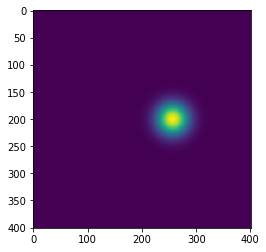

In [10]:
plt.imshow(qfunc(state, xvec, xvec))

In [11]:
1597267.0 

1597267.0

In [ ]:
%lprun -f qfunc2 qfunc2(state, AMAT_pwr)

In [97]:
244207.0 

244207.0

In [ ]:
out = qfunc2(state, AMAT_pwr)
plt.imshow(out)

In [15]:
for n in [10, 20, 50, 100, 1000]:
    print(n)
    b = np.random.rand(n, n) + 1j * np.random.rand(n, n)
    %timeit b.real**2 + b.imag**2
    %timeit np.abs(b)**2
    %timeit b * b.conj()

10
3.5 µs ± 26.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.11 µs ± 2.75 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.63 µs ± 14 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
20
4.05 µs ± 15 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
7.5 µs ± 211 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.18 µs ± 11.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
50
8.7 µs ± 31.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
36.8 µs ± 67.4 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
7.02 µs ± 27.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
100
29.8 µs ± 471 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
140 µs ± 1.49 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
29 µs ± 21.1 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1000
10.8 ms ± 261 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
20.5 ms ± 910 µs per loop 

326 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


602 ms ± 42.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


448 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [107]:
% timeit qfunc2(state, AMAT_pwr)

17.8 ms ± 815 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [106]:
% timeit qfunc(state, xvec, xvec)

C:\Programs\Anaconda3\envs\Intelpython\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  # Remove the CWD from sys.path while we load stuff.


82.5 ms ± 3.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
% timeit qfunc_amat(xvec, xvec, N)

In [ ]:
qfunc_amat(xvec, xvec, N)

In [28]:
ket2dm(tensor(coherent(10, 1), coherent(5, 0)))

Quantum object: dims = [[10, 5], [10, 5]], shape = (50, 50), type = oper, isherm = True
Qobj data =
[[0.36787944 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]